In [1]:
import tensorflow as tf
from tensorflow.keras import models,layers
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
data_dir = "/content/drive/My Drive/PlantVillage"
Image_size=256
Batch_size=32
Channels = 3
Epochs = 50

In [4]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    shuffle=True,
    image_size=(Image_size, Image_size),
    batch_size=Batch_size
)

Found 2165 files belonging to 4 classes.


In [5]:
class_names = dataset.class_names
class_names

['Models', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [6]:
len(dataset)

68

In [7]:
for image_batch, label_batch in dataset.take(1):
  print(image_batch.shape)
  print(label_batch.numpy())

(32, 256, 256, 3)
[2 2 1 1 1 2 1 1 2 1 3 3 2 1 2 1 2 2 1 2 1 1 1 1 1 1 1 2 3 2 1 2]


In [8]:
for image_batch, label_batch in dataset.take(1):
  print(image_batch[0].numpy())

[[[116. 107. 110.]
  [111. 102. 105.]
  [111. 102. 105.]
  ...
  [133. 127. 129.]
  [144. 138. 140.]
  [154. 148. 150.]]

 [[102.  93.  96.]
  [104.  95.  98.]
  [111. 102. 105.]
  ...
  [139. 133. 135.]
  [142. 136. 138.]
  [147. 141. 143.]]

 [[ 96.  87.  90.]
  [101.  92.  95.]
  [109. 100. 103.]
  ...
  [142. 136. 138.]
  [142. 136. 138.]
  [143. 137. 139.]]

 ...

 [[148. 146. 151.]
  [142. 140. 145.]
  [118. 116. 121.]
  ...
  [179. 177. 182.]
  [178. 176. 181.]
  [178. 176. 181.]]

 [[134. 132. 137.]
  [125. 123. 128.]
  [100.  98. 103.]
  ...
  [181. 179. 184.]
  [182. 180. 185.]
  [182. 180. 185.]]

 [[161. 159. 164.]
  [139. 137. 142.]
  [ 98.  96. 101.]
  ...
  [174. 172. 177.]
  [175. 173. 178.]
  [176. 174. 179.]]]


Visualize

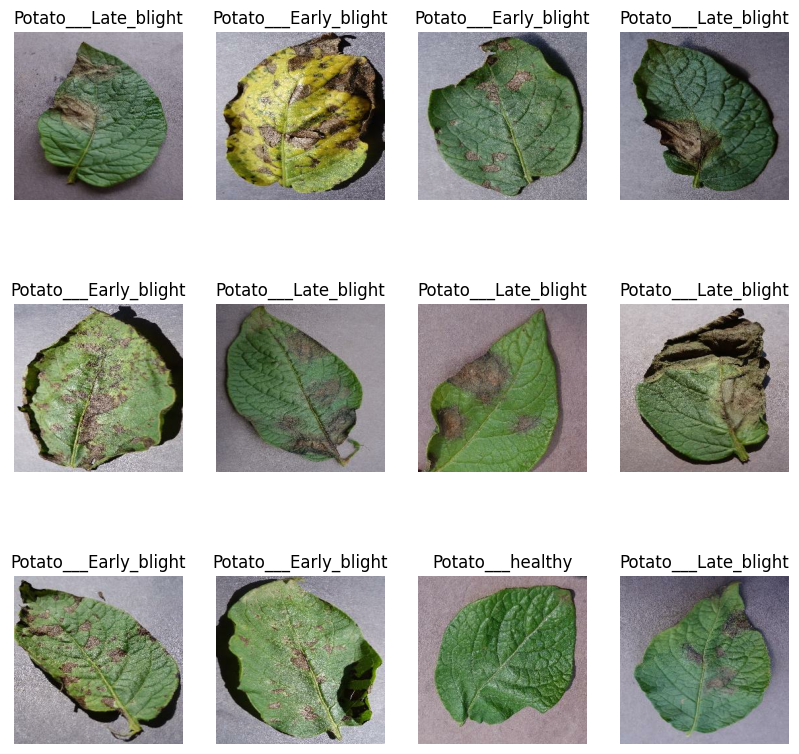

In [9]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
  for i in range(12):
    plt.subplot(3,4,i+1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    plt.title(class_names[label_batch[i]])
    plt.axis("off")


In [10]:
len(dataset)

68

Training and Testing

In [11]:
train_size=0.8
len(dataset)*train_size

54.400000000000006

In [12]:
train_ds=dataset.take(54)
len(train_ds)

54

In [13]:
test_ds = dataset.skip(54)
len(test_ds)

14

In [14]:
val_size=0.1
len(dataset)*val_size

6.800000000000001

In [15]:
val_ds= test_ds.take(6)
len(val_ds)

6

In [16]:
test_ds = test_ds.skip(6)
len(test_ds)

8

In [17]:
def get_dataset_partitions_tf(ds,train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True,shuffle_size=10000):

  ds_size=len(ds)
  if shuffle:
    ds=ds.shuffle(shuffle_size,seed=12)

  train_size=int(train_split*ds_size)
  val_size=int(val_split*ds_size)

  train_ds=ds.take(train_size)
  val_ds=ds.skip(train_size).take(val_size)
  test_ds=ds.skip(train_size).skip(val_size)
  return train_ds,val_ds,test_ds

In [18]:
train_ds,val_ds,test_ds=get_dataset_partitions_tf(dataset)

In [19]:
len(train_ds)

54

In [20]:
len(val_ds)

6

In [21]:
len(test_ds)

8

In [22]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

Preprocessing

In [23]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(Image_size, Image_size),
    layers.Rescaling(1.0/255)
])


In [24]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2)
])

Convolutional Neural Network

In [25]:
input_shape=(Batch_size,Image_size,Image_size,Channels)
n_classes=3

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32,(3,3),activation = 'relu',input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(n_classes,activation='softmax'),
    ])

model.build(input_shape=(None, 256, 256, 3))


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [26]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 12, 12, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 4, 4, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 2, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

In [27]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [28]:
history = model.fit(
    train_ds,
    epochs=Epochs,
    batch_size=Batch_size,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 619s 135ms/step - accuracy: 0.0418 - loss: nan - val_accuracy: 0.0000e+00 - val_loss: nan
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 9s 54ms/step - accuracy: 0.0000e+00 - loss: nan - val_accuracy: 0.0000e+00 - val_loss: nan
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - accuracy: 0.0000e+00 - loss: nan - val_accuracy: 0.0000e+00 - val_loss: nan
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - accuracy: 0.0000e+00 - loss: nan - val_accuracy: 0.0000e+00 - val_loss: nan
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - accuracy: 0.0000e+00 - loss: nan - val_accuracy: 0.0000e+00 - val_loss: nan
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - accuracy: 0.0000e+00 - loss: nan - val_accuracy: 0.0000e+00 - val_loss: nan
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - accuracy: 0.0000e+00 - loss: nan - val_accuracy: 0.0000e+00 - val_loss: nan
Epoch 8/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 0.0000e+00 - loss: nan - val_accura

In [29]:
scores = model.evaluate(test_ds)

8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.0000e+00 - loss: nan


In [30]:
scores

[nan, 0.0]

In [31]:
history

In [32]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [33]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [34]:
len(history.history['accuracy'])

50

In [35]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

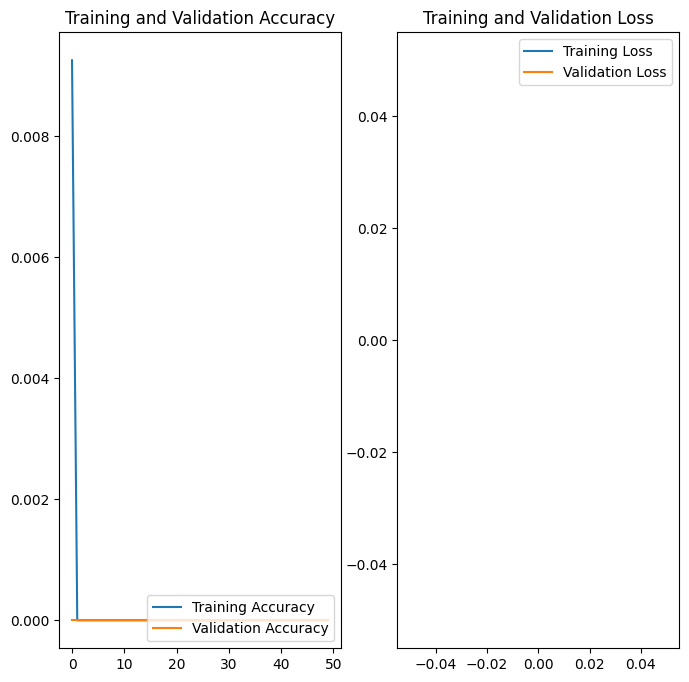

In [37]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(Epochs),acc,label='Training Accuracy')
plt.plot(range(Epochs),val_acc,label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(Epochs),loss,label='Training Loss')
plt.plot(range(Epochs),val_loss,label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()



In [38]:
# before use softmax and apply value to argmax
import numpy as np
np.argmax([2.09843006e-06 ,9.99997854e-01, 1.09281924e-10])

np.int64(1)

first image to predict
first image actual label: Potato___Late_blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
predicted label: Models


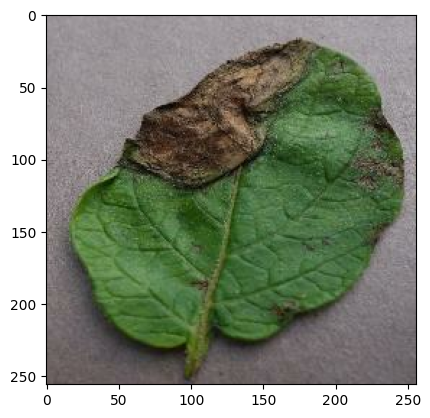

In [39]:
for image_batch,label_batch in test_ds.take(1):
  first_image= image_batch[0].numpy().astype('uint8')
  first_label = label_batch[0]

#Actual Label
  print("first image to predict")
  plt.imshow(first_image)
  print("first image actual label:",class_names[first_label])

#Predicted Label
  batch_prediction = model.predict(image_batch)
  print("predicted label:",class_names[np.argmax(batch_prediction[0])])



In [40]:
def predict(model,img):
  img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
  img_array = tf.expand_dims(img_array,0)

  predictions = model.predict(img_array)

  predicted_class = class_names[np.argmax(predictions[0])]
  confidence = round(100*(np.max(predictions[0])),2)
  return predicted_class,confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


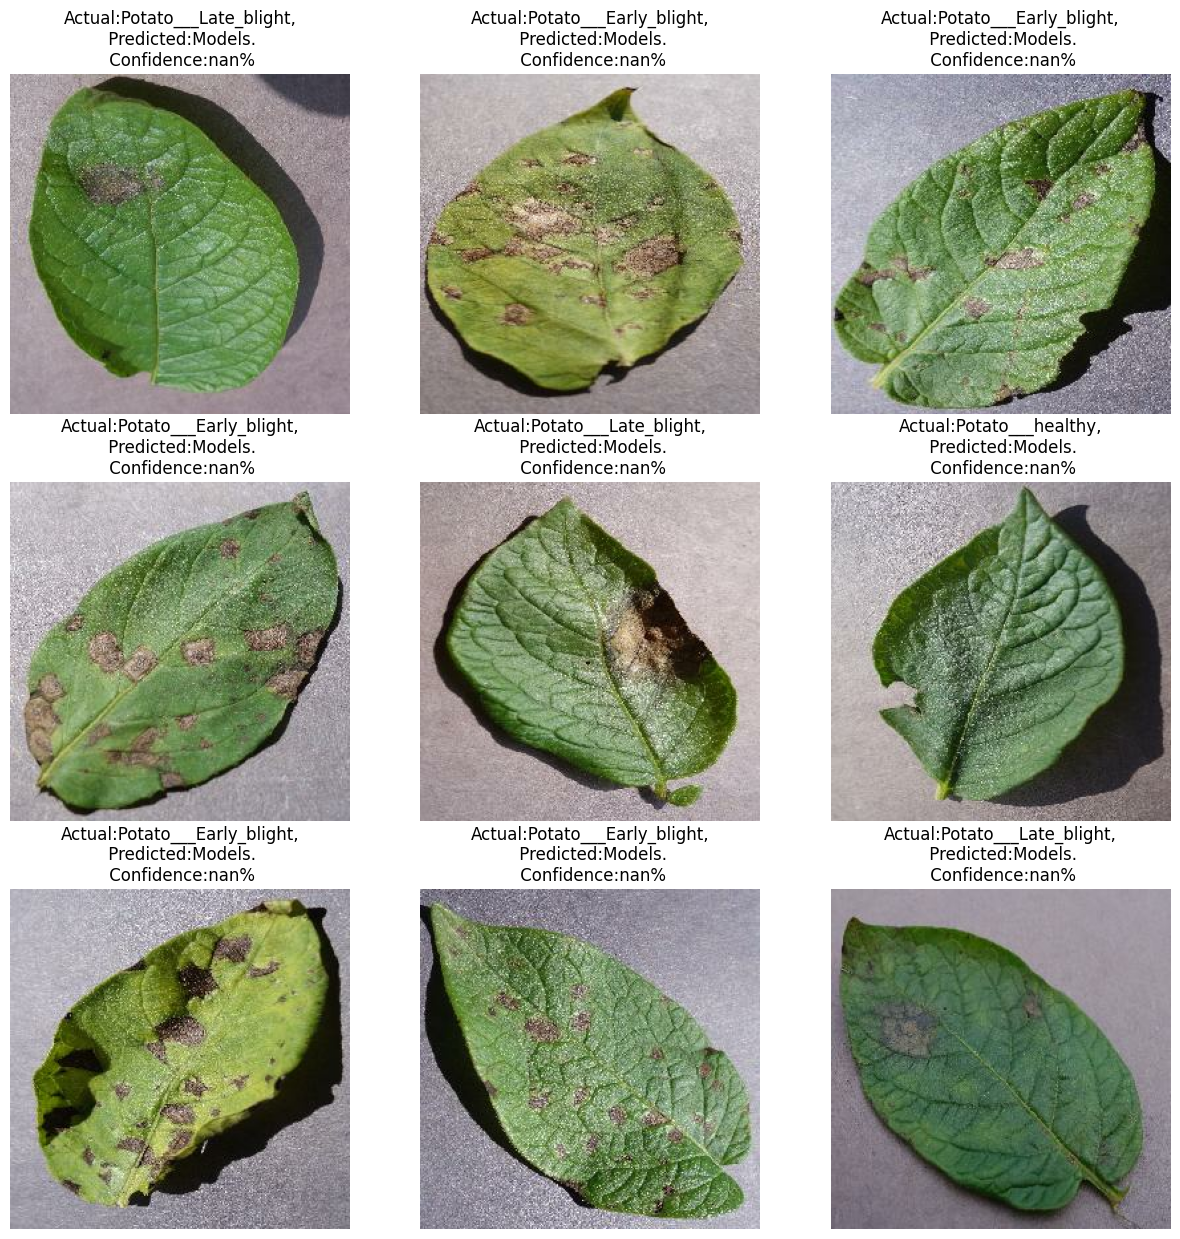

In [41]:
plt.figure(figsize=(15,15))
for images,labels in test_ds.take(1):
  for i in range(9):
    ax=plt.subplot(3,3,i+1)
    plt.imshow(images[i].numpy().astype("uint8"))

    predicted_class,confidence = predict(model,images[i].numpy())
    actual_class = class_names[labels[i]]
    plt.title(f"Actual:{actual_class},\n Predicted:{predicted_class}.\n Confidence:{confidence}%")

    plt.axis("Off")


In [42]:
import os, re

models_dir = "/content/drive/My Drive/PlantVillage/Models/"

# find latest version
model_version = max(
    [int(re.search(r"model(\d+)\.keras", f).group(1)) for f in os.listdir(models_dir) if f.endswith(".keras")] + [0]
) + 1

# save with new version
model.save(f"{models_dir}/model{model_version}.keras")


In [44]:
import tensorflow as tf

# Suppose your trained model is called `model`
# Save it in SavedModel format
# Export your trained model for TensorFlow Serving
model.export("/content/saved_model/my_model")



Saved artifact at '/content/saved_model/my_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  140044792220176: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140044792220944: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140044792230544: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140044792231312: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140044792226896: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140044792229200: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140044792232464: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140044792231696: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140044792232848: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140044792232656: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1

In [45]:
!ls /content/saved_model/my_model


assets	fingerprint.pb	saved_model.pb	variables


In [46]:
!zip -r saved_model.zip saved_model/


  adding: saved_model/ (stored 0%)
  adding: saved_model/my_model/ (stored 0%)
  adding: saved_model/my_model/fingerprint.pb (stored 0%)
  adding: saved_model/my_model/variables/ (stored 0%)
  adding: saved_model/my_model/variables/variables.data-00000-of-00001 (deflated 100%)
  adding: saved_model/my_model/variables/variables.index (deflated 71%)
  adding: saved_model/my_model/assets/ (stored 0%)
  adding: saved_model/my_model/saved_model.pb (deflated 87%)


In [47]:
from google.colab import files
files.download("saved_model.zip")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>